# Code for Hierarchical Clustering to obtain labels (suitability category)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
# Set seed for whole notebook
import random
random.seed(10)

In [3]:
#Loading locational dataset
df = pd.read_csv('final-scaled-df.csv', index_col='FIPS')
df.head(20)

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed
FIPS,,,,,,,,,,,,,,,,,,,
51001,0.185901,0.601097,0.020793,0.606148,0.417871,0.931630,0.075854,0.148920,0.319901,0.435870,0.410805,0.412876,0.398849,0.223717,0.178736,0.296552,0.064338,0.289624,1
51003,0.354645,0.494455,0.157825,0.754033,0.718885,0.000000,0.108095,0.182011,0.281478,0.361577,0.330150,0.398268,0.652957,0.669414,0.672845,0.580575,0.679813,0.081093,1
51005,0.654945,0.494455,0.083128,0.898739,0.622105,0.000000,0.187226,0.147870,0.208440,0.382735,0.309672,0.361536,0.590581,0.651482,0.660489,0.531379,0.897165,0.020858,1
51007,0.648261,0.515919,0.018988,0.896297,0.404927,0.861198,0.157467,0.144258,0.319836,0.347694,0.488828,0.370654,0.753323,0.808243,0.809483,0.716207,0.651586,0.155517,1
51009,0.236541,0.502679,0.145085,0.660592,0.706138,0.819049,0.184217,0.145333,0.205452,0.416978,0.325681,0.367647,0.499006,0.525380,0.539368,0.463678,0.770831,0.072140,1
51011,0.099752,0.516467,0.082587,0.471095,0.621123,0.862305,0.140248,0.158561,0.278259,0.427413,0.398133,0.403431,0.427002,0.337238,0.280747,0.347356,0.662506,0.159655,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.000000,0.142115,0.105105,0.229655,0.409510,0.284420,0.314118,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1
51015,0.421279,0.494455,0.126500,0.794329,0.685401,0.000000,0.197927,0.147820,0.225123,0.379990,0.321457,0.383072,0.615071,0.686479,0.682759,0.561379,0.582228,0.137797,1
51017,0.165266,0.000000,0.098558,0.579941,0.647728,0.000000,0.382682,0.130588,0.262562,0.372108,0.370891,0.394608,0.681005,0.768185,0.779741,0.641724,0.899831,0.020852,1


In [58]:
TEST_RATIO = 0.2
BATCH_SIZE = 64

size_all = len(df)

# training/val/test dataset
size_train = size_all - 6
size_val = int(size_train * TEST_RATIO)
size_train_sub = size_train - size_val

# split data into train and test
# Test = 6 counties of interst: Accomack, Fauquier, Greensville, Hanover, Rockingham, Wise
dataset_val = df.loc[[51001, 51061, 51081, 51085, 51165, 51195]]

# Train = all except 6 counties of interest
dataset_train = df.drop([51001, 51061, 51081, 51085, 51165, 51195])


# Reforestation Clustering

In [5]:
cols = ['Income', 'DSCI', 'PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest', 
        'Agriculture', 'Biomass', 'Power', 'Water Availability', 'Watershed',
       'Log_Bio','Log_Water','Log_Power']


# Using the elbow method to determine the k value to be applied
k_rng = range(1, 10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Log_Water']])
    sse.append(km.inertia_)

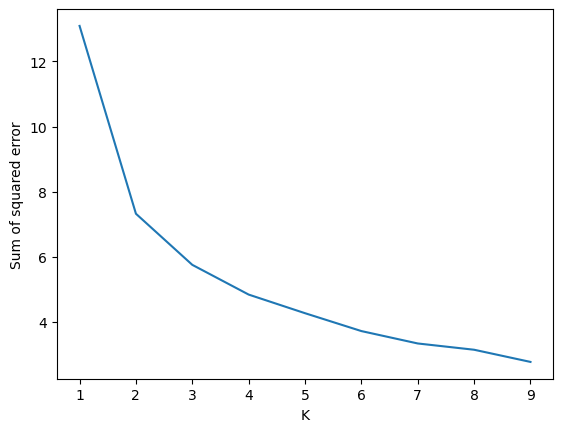

In [6]:
# Plot to obtain elbow
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

In [7]:
# create clusters using k value = 4
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [8]:
# Determining mean cluster characterisitics REFORESTATION
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Water Availability', 'Log_Water']])
dataset_train['Reforest'] = y_hc
dataset_train.sort_values("Reforest", inplace = True, ascending=True)

#average input vars by cluster
df_rfcluster = dataset_train.groupby('Reforest').mean()


# Determining mean cluster characterisitics ENHANCED WEATHERING
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Power', 'Log_Power', 'Agriculture']])
dataset_train['EW'] = y_hc
dataset_train.sort_values("EW", inplace = True, ascending=True)

#average input vars by cluster
df_ewcluster = dataset_train.groupby('EW').mean()


# Determining mean cluster characterisitics BIOCHAR
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Biomass', 'Log_Bio','Agriculture']])
dataset_train['Biochar'] = y_hc
dataset_train.sort_values("Biochar", inplace = True, ascending=True)

#average input vars by cluster
df_biocluster = dataset_train.groupby('Biochar').mean()

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: ylabel='Biochar'>

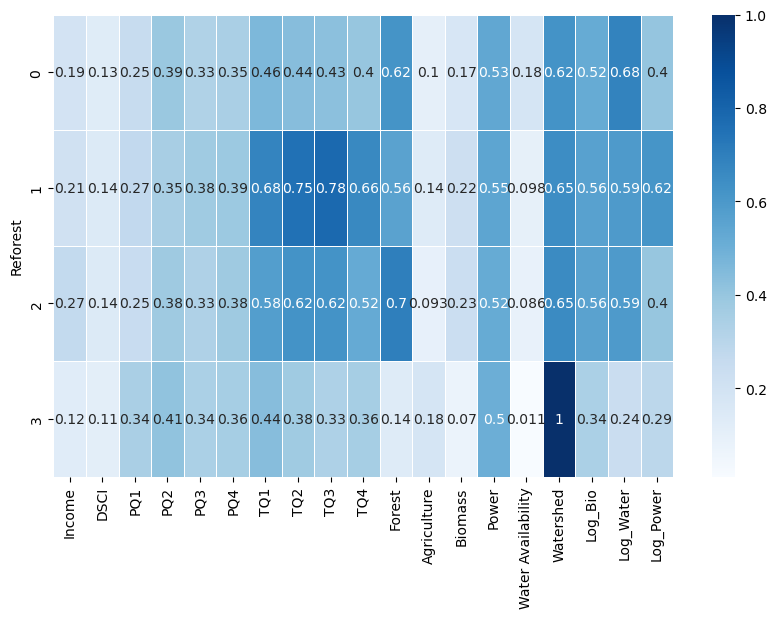

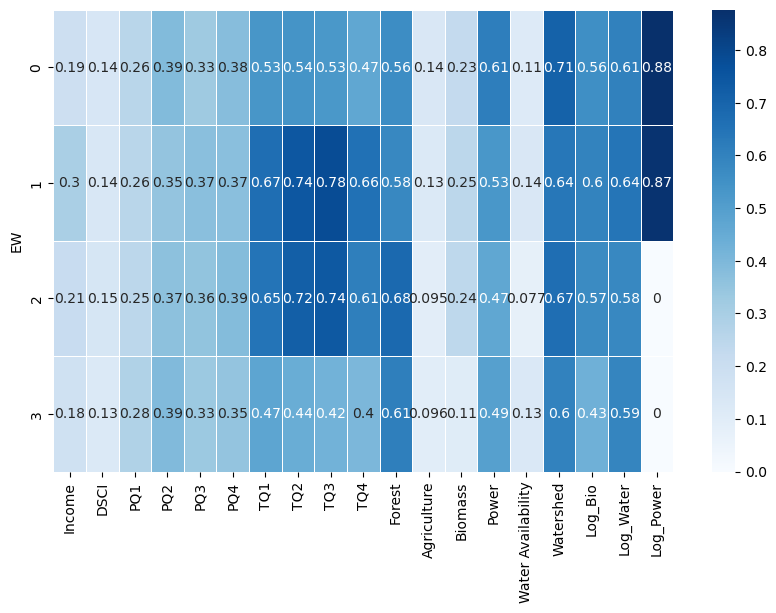

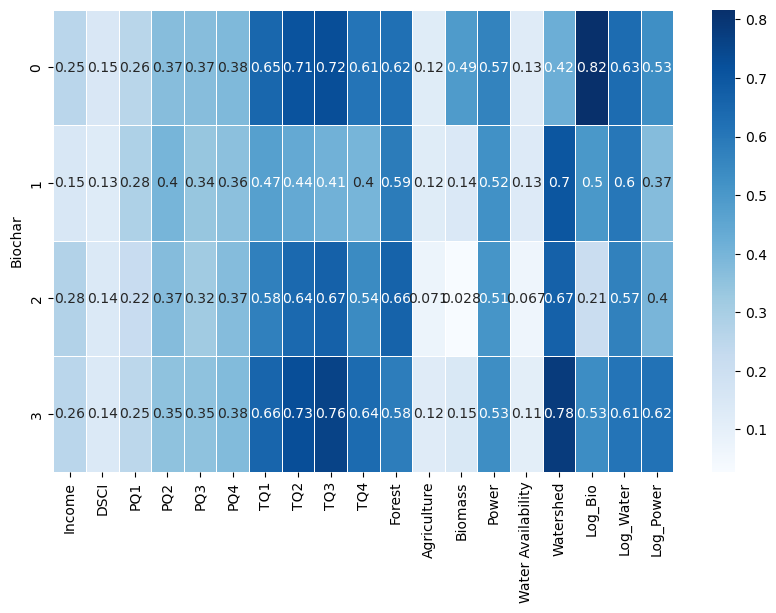

In [9]:
#Heatmap of cluster characteristics reforestation
plt.figure(figsize=(10,6))
sns.heatmap(df_rfcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_ewcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_biocluster[cols], annot=True, cmap="Blues", linewidths=.5)

In [10]:
# see how clusters are distributed
dataset_train['Reforest'].value_counts()

1    31
2    26
0    24
3     3
Name: Reforest, dtype: int64

In [11]:
dataset_train['EW'].value_counts()

0    24
1    22
3    20
2    18
Name: EW, dtype: int64

In [12]:
dataset_train['Biochar'].value_counts()

1    30
3    23
0    19
2    12
Name: Biochar, dtype: int64

In [13]:
# Look at counties in smallest cluster
dataset_train[dataset_train['Reforest'] == 3]

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,...,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed,Reforest,EW,Biochar
FIPS,,,,,,,,,,,,,,,,,,,,,
51115,0.006277,0.494455,0.000000,0.076886,0.000000,0.00000,0.131867,0.118457,0.362594,0.415861,...,0.411094,0.293565,0.254598,0.315172,0.224077,0.094584,1,3,3,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.00000,0.142115,0.105105,0.229655,0.409510,...,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1,3,3,1
51131,0.100844,0.519490,0.007939,0.473371,0.285964,0.86796,0.099351,0.117189,0.439573,0.415893,...,0.467713,0.404628,0.346264,0.386092,0.098323,0.449594,1,3,0,1


# Label the clusters as suitability levels

In [14]:
# Maybe redo if we can get more data and redo clusters

# 0 = highly suitable (most forest land, mild summer temps, warm winter temps, faitly high precip, high income, avg drought)
# 2 = suitable (high income, high summer and wimter temps, high rain, good about of forest)
# 1 = possible (lots of forest land, slightly cold, lots of rain, not the best income)
# 3 = unsuitable (too cold, too little forest land, low income)

# Supervised ML for suitability prediction

# Random Forest

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [16]:
# Reading data
# df = pd.read_csv("Labelled Normalised DACCS data.csv")

In [17]:
# creating input identity
sub_df = dataset_train[cols]
X = sub_df
y = dataset_train[['Reforest','EW','Biochar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [18]:
y_train_rf = y_train[['Reforest']]
y_train_ew = y_train[['EW']]
y_train_bio = y_train[['Biochar']]

y_test_rf = y_test[['Reforest']]
y_test_ew = y_test[['EW']]
y_test_bio = y_test[['Biochar']]

In [19]:
# creating Model (with 100 trees)
rf_rf = RandomForestClassifier(n_estimators=100)
rf_ew = RandomForestClassifier(n_estimators=100)
rf_bio = RandomForestClassifier(n_estimators=100)

In [20]:
# Fitting training data
rf_rf.fit(X_train, y_train_rf)
rf_ew.fit(X_train, y_train_ew)
rf_bio.fit(X_train, y_train_bio)

/var/folders/bn/jw4b363n6cz8jy9jwmhp7q0c0000gn/T/ipykernel_99608/1459246705.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_rf.fit(X_train, y_train_rf)
/var/folders/bn/jw4b363n6cz8jy9jwmhp7q0c0000gn/T/ipykernel_99608/1459246705.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_ew.fit(X_train, y_train_ew)
/var/folders/bn/jw4b363n6cz8jy9jwmhp7q0c0000gn/T/ipykernel_99608/1459246705.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_bio.fit(X_train, y_train_bio)


RandomForestClassifier()

In [21]:
# see which counties are in test
y_test_rf.index

Int64Index([51083, 51193, 51155, 51197, 51119, 51099, 51107, 51011, 51041,
            51139, 51017, 51057, 51105, 51179, 51157, 51177, 51089],
           dtype='int64', name='FIPS')

In [22]:
#make predictions
y_pred_rf = rf_rf.predict(X_test)
y_pred_ew = rf_rf.predict(X_test)
y_pred_bio = rf_rf.predict(X_test)

#for pred_label, true_label, index in zip(y_pred_ew, y_test_ew, y_test_ew.index):
 #   print(pred_label, true_label, index)

In [23]:
# To get model performance 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      0.88      0.82         8
           2       0.67      0.50      0.57         4

    accuracy                           0.82        17
   macro avg       0.81      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17
 

EW:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.86      0.75         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3

    accuracy                           0.53        17
   macro avg       0.32      0.36      0.34        17
weighted avg       0.45      0.53      0.49        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [24]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8235294117647058 

EW Accuracy: 0.5294117647058824 

Biochar Accuracy: 0.11764705882352941 



In [25]:
# Determining feature importance (Model Interpretation)
feature_imp_rf = pd.DataFrame(rf_rf.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Reforestation:\n' , feature_imp_rf , "\n")

feature_imp_ew = pd.DataFrame(rf_ew.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")

feature_imp_bio = pd.DataFrame(rf_bio.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                     importance
TQ4                   0.200203
TQ2                   0.140261
TQ3                   0.118215
TQ1                   0.111330
Forest                0.075255
PQ4                   0.051062
Water Availability    0.041476
Agriculture           0.039216
DSCI                  0.037204
Log_Water             0.034203
PQ3                   0.032981
PQ2                   0.029837
PQ1                   0.026737
Biomass               0.015470
Log_Power             0.012849
Income                0.012513
Log_Bio               0.010021
Power                 0.010001
Watershed             0.001166 

Enhanced Weathering:
                     importance
Log_Power             0.195022
Power                 0.163181
TQ3                   0.130719
TQ4                   0.119069
TQ2                   0.083734
PQ2                   0.050309
TQ1                   0.044215
Income                0.031771
PQ1                   0.025137
Forest                0.022184

<Axes: >

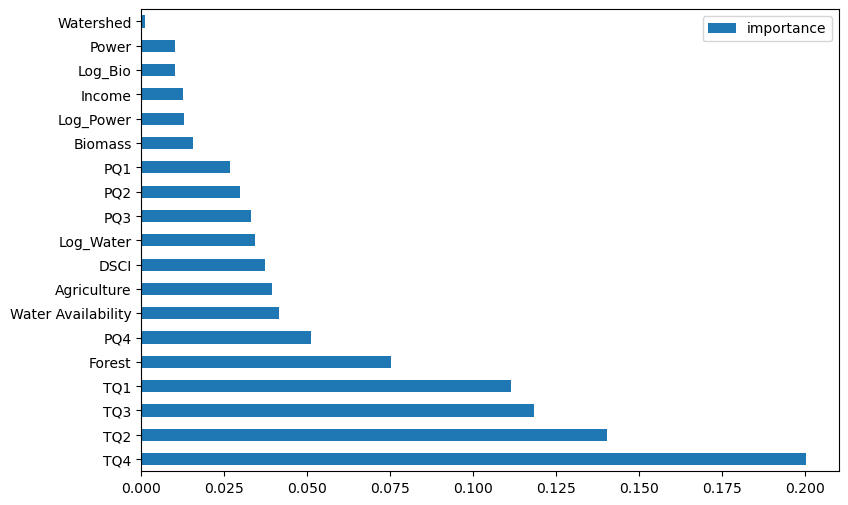

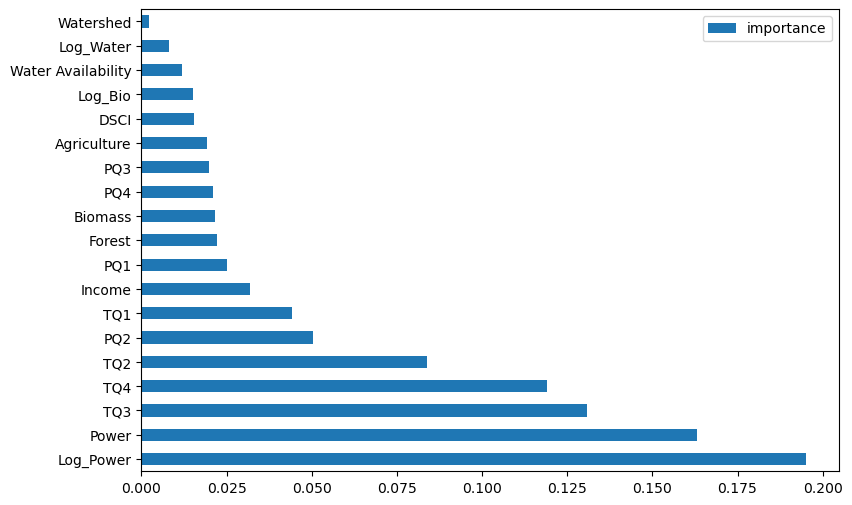

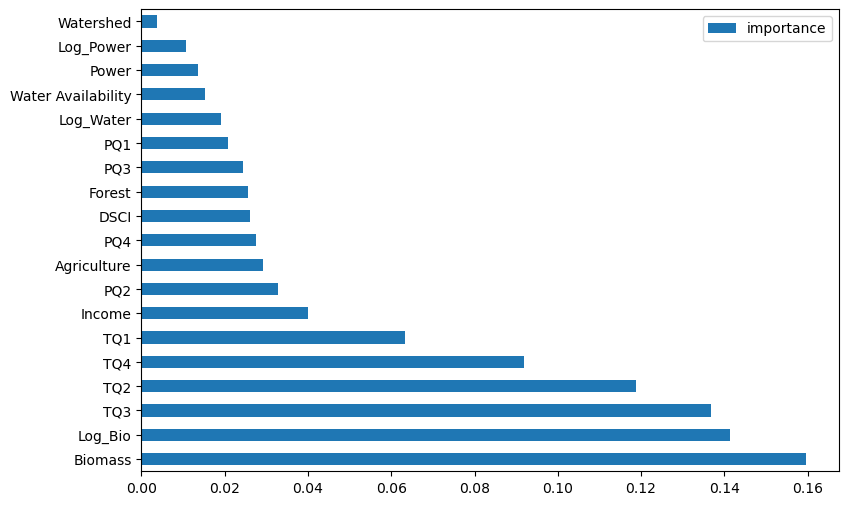

In [26]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Logistic Regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [28]:
logreg_model_rf = LogisticRegression()
logreg_model_ew = LogisticRegression()
logreg_model_bio = LogisticRegression()

logreg_model_rf.fit(X_train, y_train_rf)
logreg_model_ew.fit(X_train, y_train_ew)
logreg_model_bio.fit(X_train, y_train_bio)

# predict
y_pred_rf = logreg_model_rf.predict(X_test)
y_pred_ew = logreg_model_ew.predict(X_test)
y_pred_bio = logreg_model_bio.predict(X_test)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# To get model performance Reforest
from sklearn.metrics import classification_report
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.57      0.73         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           0.82        17
   macro avg       0.91      0.89      0.87        17
weighted avg       0.89      0.82      0.82        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1

In [30]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.8235294117647058 

Biochar Accuracy: 0.8823529411764706 



In [31]:
feature_names = X_train.columns

coeffs_rf = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_rf.coef_[0]})
coeffs_ew = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_ew.coef_[0]})
coeffs_bio = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_bio.coef_[0]})

coeffs_rf['Abs_Coefficient'] = abs(coeffs_rf['Coefficient'])
coeffs_ew['Abs_Coefficient'] = abs(coeffs_ew['Coefficient'])
coeffs_bio['Abs_Coefficient'] = abs(coeffs_bio['Coefficient'])

coeffs_rf.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_ew.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_bio.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

<Axes: ylabel='Feature'>

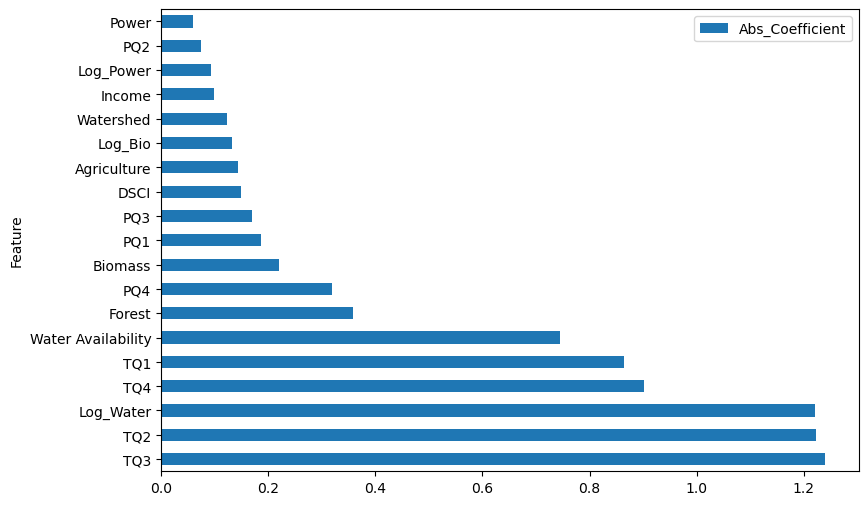

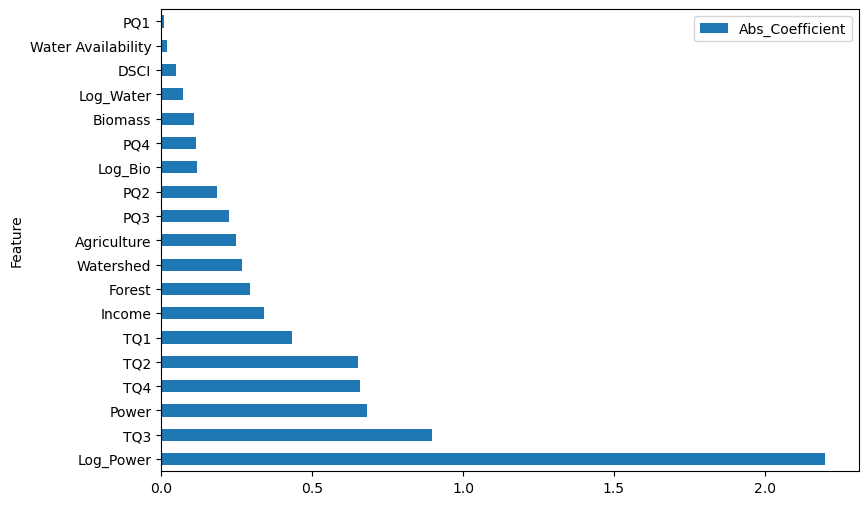

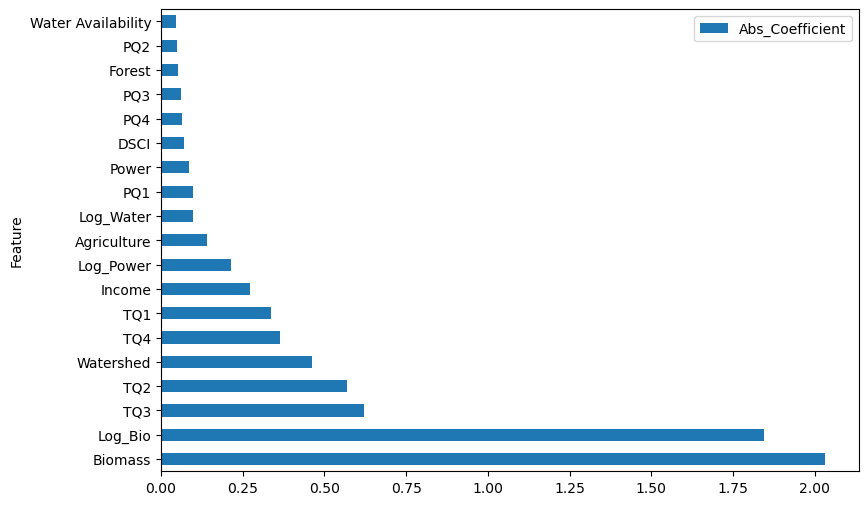

In [32]:
#Feature importance visualisation
coeffs_rf.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_ew.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_bio.plot(kind='barh', x='Feature', y='Abs_Coefficient')

# Descision Tree

In [33]:
# supervised learning method
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [34]:
dt_model_rf = DecisionTreeClassifier(random_state=0)
dt_model_ew = DecisionTreeClassifier(random_state=0)
dt_model_bio = DecisionTreeClassifier(random_state=0)

dt_model_rf.fit(X_train, y_train_rf)
dt_model_ew.fit(X_train, y_train_ew)
dt_model_bio.fit(X_train, y_train_bio)

y_pred_rf = dt_model_rf.predict(X_test)
y_pred_ew = dt_model_ew.predict(X_test)
y_pred_bio = dt_model_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.92      0.93        17
weighted avg       0.95      0.94      0.94        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1

In [35]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.9411764705882353 

EW Accuracy: 1.0 

Biochar Accuracy: 0.7647058823529411 



In [36]:
print('Reforestation:\n',cross_val_score(dt_model_rf, X_train, y_train_rf, cv=10),'\n')
print('EW:\n',cross_val_score(dt_model_ew, X_train, y_train_ew, cv=10),'\n')
print('Biochar:\n',cross_val_score(dt_model_bio, X_train, y_train_bio, cv=10),'\n')

Reforestation:
 [0.71428571 0.57142857 1.         0.71428571 0.71428571 0.85714286
 1.         0.66666667 0.83333333 1.        ] 

EW:
 [1.         1.         1.         1.         1.         1.
 1.         1.         0.83333333 1.        ] 

Biochar:
 [0.85714286 0.71428571 0.85714286 0.85714286 0.42857143 0.71428571
 0.57142857 0.66666667 1.         0.83333333] 



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


# KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
n_acc_rf = [0]*11
n_acc_ew = [0]*11
n_acc_bio = [0]*11

print('Reforestation:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_rf = KNeighborsClassifier(n_neighbors=n)
    
    neigh_rf.fit(X_train, y_train_rf)
    
    preds_rf = neigh_rf.predict(X_test)
    
    correct_rf = 0
    
    for i in range(len(preds_rf)):
        if preds_rf[i]==y_test_rf.values[i]:
            correct_rf += 1
    acc_rf = correct_rf/len(preds_rf)
    n_acc_rf[n] = acc_rf
    print(f'{n} neighbors - validation accuracy: {round(acc_rf, 5)} {correct_rf}/{len(preds_rf)}')
    
print('\nEW:')   
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_ew = KNeighborsClassifier(n_neighbors=n)
    
    neigh_ew.fit(X_train, y_train_ew)
    
    preds_ew = neigh_ew.predict(X_test)
    
    correct_ew = 0
    
    for i in range(len(preds_ew)):
        if preds_ew[i]==y_test_ew.values[i]:
            correct_ew += 1
    acc_ew = correct_ew/len(preds_ew)
    n_acc_ew[n] = acc_ew
    print(f'{n} neighbors - validation accuracy: {round(acc_ew, 5)} {correct_ew}/{len(preds_ew)}')

print('\nBiochar:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_bio = KNeighborsClassifier(n_neighbors=n)
    
    neigh_bio.fit(X_train, y_train_bio)
    
    preds_bio = neigh_bio.predict(X_test)
    
    correct_bio = 0
    
    for i in range(len(preds_bio)):
        if preds_bio[i]==y_test_bio.values[i]:
            correct_bio += 1
    acc_bio = correct_bio/len(preds_bio)
    n_acc_bio[n] = acc_bio
    print(f'{n} neighbors - validation accuracy: {round(acc_bio, 5)} {correct_bio}/{len(preds_bio)}')

Reforestation:
1 neighbors - validation accuracy: 0.82353 14/17
2 neighbors - validation accuracy: 0.64706 11/17
3 neighbors - validation accuracy: 0.82353 14/17
4 neighbors - validation accuracy: 0.76471 13/17
5 neighbors - validation accuracy: 0.82353 14/17
6 neighbors - validation accuracy: 0.82353 14/17
7 neighbors - validation accuracy: 0.82353 14/17
8 neighbors - validation accuracy: 0.70588 12/17
9 neighbors - validation accuracy: 0.70588 12/17
10 neighbors - validation accuracy: 0.76471 13/17

EW:
1 neighbors - validation accuracy: 0.94118 16/17
2 neighbors - validation accuracy: 0.82353 14/17
3 neighbors - validation accuracy: 0.82353 14/17
4 neighbors - validation accuracy: 0.82353 14/17
5 neighbors - validation accuracy: 0.82353 14/17
6 neighbors - validation accuracy: 0.70588 12/17
7 neighbors - validation accuracy: 0.82353 14/17
8 neighbors - validation accuracy: 0.82353 14/17
9 neighbors - validation accuracy: 0.82353 14/17
10 neighbors - validation accuracy: 0.82353 14/1

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when

Text(0.5, 1.0, 'Biochar Validation Accuracy By Number of Neighbors')

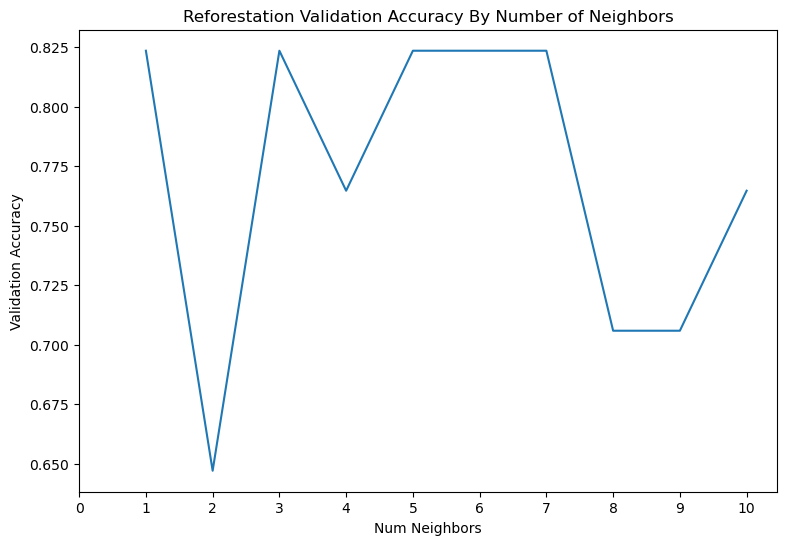

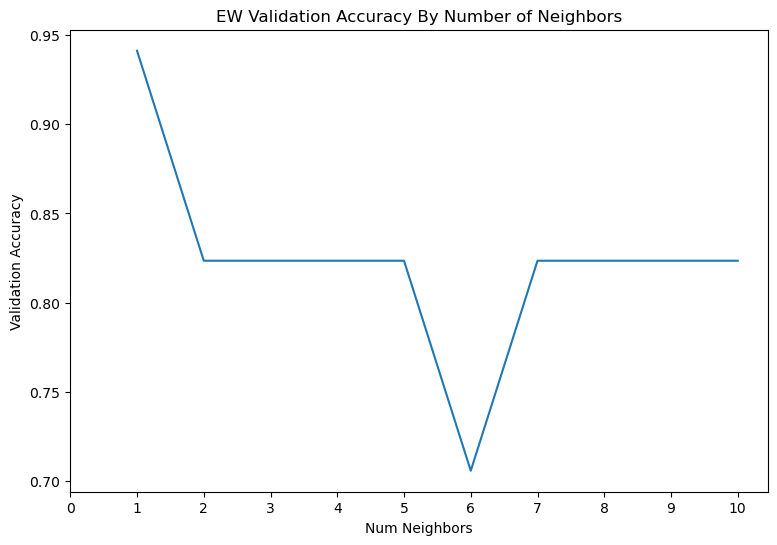

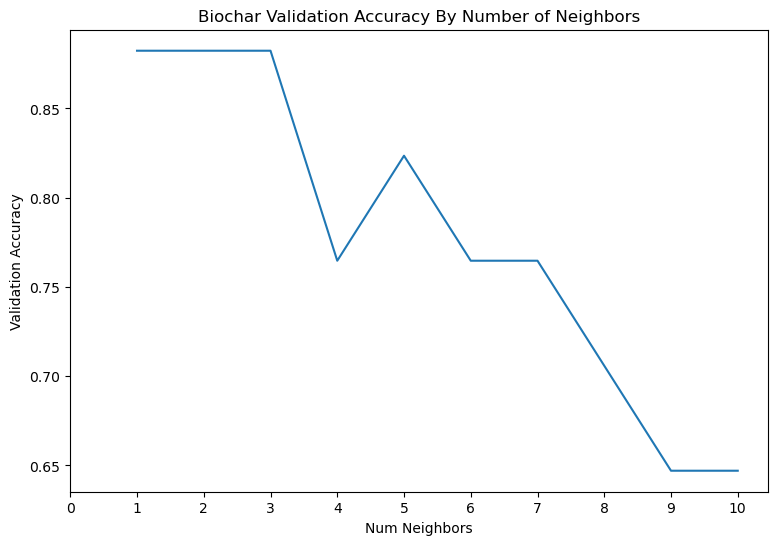

In [43]:
fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_rf))], n_acc_rf[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_rf)))
plt.title('Reforestation Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_ew))], n_acc_ew[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_ew)))
plt.title('EW Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_bio))], n_acc_bio[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_bio)))
plt.title('Biochar Validation Accuracy By Number of Neighbors')

In [44]:
neigh_rf = KNeighborsClassifier(n_neighbors=3)
neigh_ew = KNeighborsClassifier(n_neighbors=1)
neigh_bio = KNeighborsClassifier(n_neighbors=3)

neigh_rf.fit(X_train, y_train_rf)
neigh_ew.fit(X_train, y_train_ew)
neigh_bio.fit(X_train, y_train_bio)

y_pred_rf = neigh_rf.predict(X_test)
y_pred_ew = neigh_ew.predict(X_test)
y_pred_bio = neigh_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      1.00      0.89         8
           2       0.67      0.50      0.57         4

    accuracy                           0.82        17
   macro avg       0.82      0.77      0.78        17
weighted avg       0.83      0.82      0.81        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.92      0.92      0.90        17
weighted avg       0.96      0.94      0.94        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.71      1.00      0

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [45]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8235294117647058 

EW Accuracy: 0.9411764705882353 

Biochar Accuracy: 0.8823529411764706 



# Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model_rf = MultinomialNB()
naive_bayes_model_ew = MultinomialNB()
naive_bayes_model_bio = MultinomialNB()

naive_bayes_model_rf.fit(X_train, y_train_rf)
naive_bayes_model_ew.fit(X_train, y_train_ew)
naive_bayes_model_bio.fit(X_train, y_train_bio)

y_pred_rf = naive_bayes_model_rf.predict(X_test)
y_pred_ew = naive_bayes_model_ew.predict(X_test)
y_pred_bio = naive_bayes_model_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.64      0.88      0.74         8
           2       0.50      0.50      0.50         4

    accuracy                           0.65        17
   macro avg       0.71      0.59      0.60        17
weighted avg       0.71      0.65      0.63        17
 

EW:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      0.14      0.25         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           0.65        17
   macro avg       0.86      0.79      0.72        17
weighted avg       0.84      0.65      0.58        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.33      1.00      0

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-

In [47]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.6470588235294118 

EW Accuracy: 0.6470588235294118 

Biochar Accuracy: 0.35294117647058826 



# Gradient Boost

In [48]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

#fit gradient boosted stumps (trees w depth=1)
clf_rf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_rf)
clf_ew = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_ew)
clf_bio = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_bio)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_ew = clf_ew.predict(X_test)
y_pred_bio = clf_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.92      0.92      0.90        17
weighted avg       0.96      0.94      0.94        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [50]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.9411764705882353 

Biochar Accuracy: 1.0 



In [51]:
feature_imp_rf = pd.DataFrame(clf_rf.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_ew = pd.DataFrame(clf_ew.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_bio = pd.DataFrame(clf_bio.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)


print('Reforestation:\n' , feature_imp_rf , "\n")
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                       importance
TQ4                 4.632203e-01
TQ2                 2.645894e-01
Forest              1.324211e-01
Log_Water           3.932503e-02
DSCI                2.932859e-02
PQ2                 2.869351e-02
TQ1                 2.537372e-02
TQ3                 9.208790e-03
PQ1                 2.500640e-03
Income              2.099211e-03
Power               2.028610e-03
Water Availability  1.093209e-03
Agriculture         1.167350e-04
PQ3                 5.476028e-07
Log_Power           3.701208e-07
PQ4                 2.417804e-07
Biomass             1.090135e-16
Watershed           0.000000e+00
Log_Bio             0.000000e+00 

Enhanced Weathering:
                       importance
TQ3                 4.213796e-01
Log_Power           3.156683e-01
Power               1.370686e-01
TQ2                 8.985048e-02
Agriculture         3.011006e-02
TQ4                 3.950762e-03
PQ1                 9.920042e-04
DSCI                3.502673e-04
Inc

<Axes: >

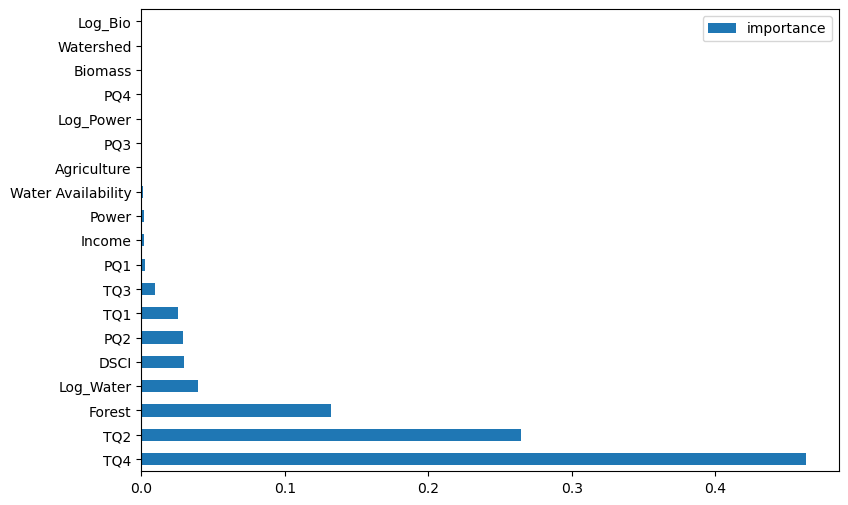

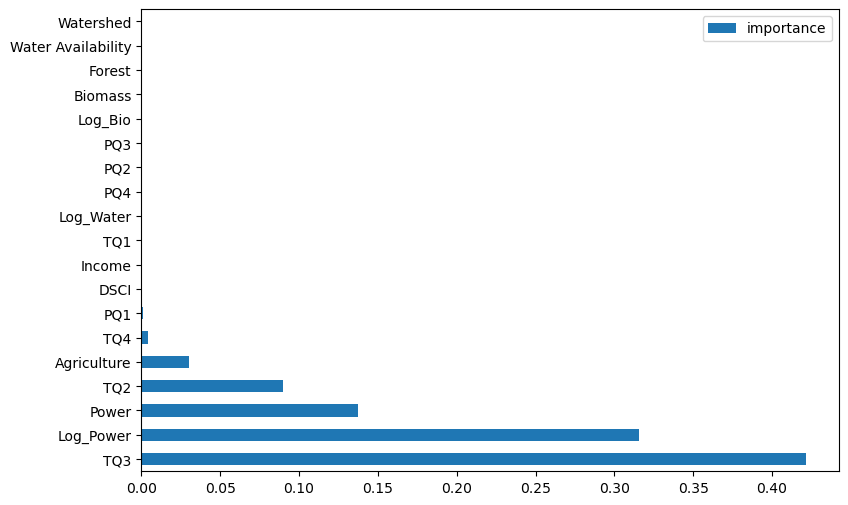

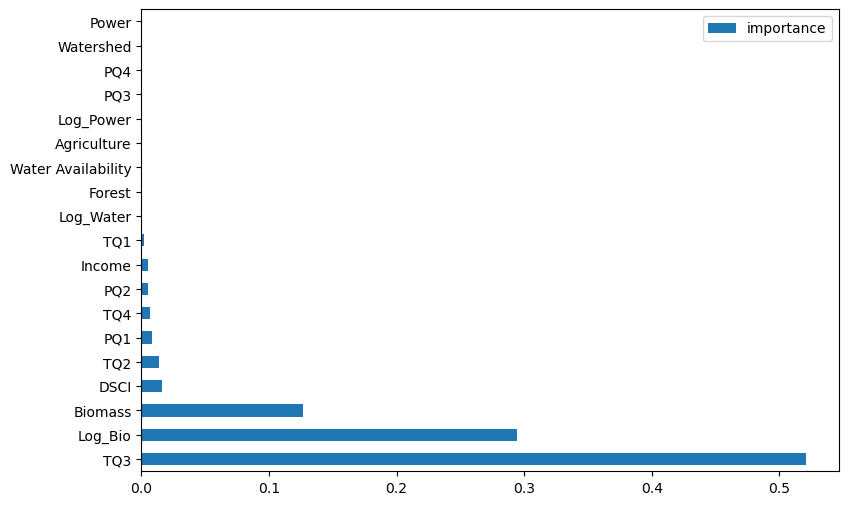

In [52]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Neural Net

## Feed Forward ANN (MLPClassifier from sklearn)

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf_rf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_rf)
clf_ew = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_ew)
clf_bio = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_bio)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Op

In [72]:
clf_rf.predict_proba(X_test)

array([[2.95897929e-03, 9.29960226e-01, 6.64798397e-02, 6.00954577e-04],
       [6.70060916e-02, 7.93123671e-01, 1.20654036e-01, 1.92162011e-02],
       [8.41205549e-02, 5.61687655e-01, 3.45744517e-01, 8.44727241e-03],
       [8.85369197e-01, 1.11985861e-02, 9.82126094e-02, 5.21960780e-03],
       [6.26315438e-04, 9.50534782e-01, 3.94956000e-02, 9.34330267e-03],
       [6.82987567e-02, 6.60701488e-01, 2.55159142e-01, 1.58406132e-02],
       [9.99935113e-01, 6.88636972e-08, 3.91346412e-05, 2.56837741e-05],
       [9.10603378e-01, 1.23853308e-03, 8.15848589e-02, 6.57322992e-03],
       [7.31161996e-01, 1.07414845e-02, 2.43009981e-01, 1.50865394e-02],
       [6.36255542e-03, 8.01221777e-01, 1.82804961e-01, 9.61070674e-03],
       [1.27925041e-02, 7.34509050e-02, 9.12249426e-01, 1.50716494e-03],
       [1.63453804e-02, 7.55388276e-01, 2.08164770e-01, 2.01015737e-02],
       [2.60798358e-02, 5.25121202e-01, 4.45402556e-01, 3.39640657e-03],
       [3.74755283e-02, 7.60566311e-01, 1.94820405e

In [74]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_ew = clf_ew.predict(X_test)
y_pred_bio = clf_bio.predict(X_test)
y_pred_rf

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0])

In [76]:
y_test_rf

,Reforest
FIPS,
51083,1
51193,1
51155,2
51197,0
51119,1
51099,1
51107,0
51011,0
51041,0


In [62]:
clf.score(X_val, y_val)

0.8823529411764706

In [77]:
print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [78]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 1.0 

Biochar Accuracy: 1.0 



## Simple ANN

In [53]:
# loading everything that might be helpful
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import torch
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [54]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [59]:
# Make data into tensor objects
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_rf_tensor = torch.tensor(y_train_rf.values, dtype=torch.float32)
y_train_ew_tensor = torch.tensor(y_train_ew.values, dtype=torch.float32)
y_train_bio_tensor = torch.tensor(y_train_bio.values, dtype=torch.float32)

y_test_rf_tensor = torch.tensor(y_test_rf.values, dtype=torch.float32)
y_test_ew_tensor = torch.tensor(y_test_ew.values, dtype=torch.float32)
y_test_bio_tensor = torch.tensor(y_test_bio.values, dtype=torch.float32)

# Make test data into tensor objects
X_val_tensor = torch.tensor(dataset_val.values, dtype=torch.float32)

In [60]:
#train data
training_data_rf = TensorDataset(X_train_tensor, y_train_rf_tensor)
train_dataloader_rf = DataLoader(training_data_rf, batch_size=64)

training_data_ew = TensorDataset(X_train_tensor, y_train_ew_tensor)
train_dataloader_ew = DataLoader(training_data_ew, batch_size=64)

training_data_bio = TensorDataset(X_train_tensor, y_train_bio_tensor)
train_dataloader_bio = DataLoader(training_data_bio, batch_size=64)


#test data
test_data_rf = TensorDataset(X_test_tensor,  y_test_rf_tensor)
test_dataloader_rf = DataLoader(test_data_rf, batch_size=64)

test_data_ew = TensorDataset(X_test_tensor,  y_test_ew_tensor)
test_dataloader_ew = DataLoader(test_data_ew, batch_size=64)

test_data_bio = TensorDataset(X_test_tensor,  y_test_bio_tensor)
test_dataloader_bio = DataLoader(test_data_bio, batch_size=64)


#validate data
val_data = TensorDataset(X_val_tensor)
val_dataloader = DataLoader(val_data, batch_size=64)

In [62]:
for X, y in test_dataloader_rf:
    y = y.long()
    print(y)

tensor([[1],
        [1],
        [2],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [1],
        [1],
        [1],
        [2],
        [2],
        [0]])


In [50]:
# Simple ANN

In [63]:
import torch.nn as nn

#define model
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(11,100), #11 input columns
            nn.Tanh(),
            nn.Linear(100,4)#4 output classes

    )

    def forward(self, x):
        logits = self.linear_model(x)
        return logits

model_rf = net()
model_ew = net()
model_bio = net()
model_rf

net(
  (linear_model): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)

In [65]:
learning_rate = 0.005
batch_size = 64
epochs = 25
loss_fn = nn.CrossEntropyLoss()
optimizer_rf = torch.optim.SGD(model_rf.parameters(), lr=learning_rate)
optimizer_ew = torch.optim.SGD(model_ew.parameters(), lr=learning_rate)
optimizer_bio = torch.optim.SGD(model_bio.parameters(), lr=learning_rate)

In [66]:
#train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() #set model in train mode
    size = len(dataloader.dataset)

    for batch, (X,y) in enumerate(dataloader):
        #prediction and loss
        #y = y.unsqueeze(1)
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)

        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if batch % 1 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [67]:
def test_loop(train_dataloader, test_dataloader, model, loss_fn):
    model.eval()  # set model in evaluation mode

    size_train = len(train_dataloader.dataset)
    size_test = len(test_dataloader.dataset)

    num_batches_train = len(train_dataloader)
    num_batches_test = len(test_dataloader)

    train_loss, correct_train = 0, 0
    test_loss, correct_test = 0, 0

    # Evaluate model on train data
    with torch.no_grad():
        for X, y in train_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches_train
    correct_train /= size_train
    print(f"Train Error: \n Accuracy: {(100*correct_train):>0.1f}%, Avg loss: {train_loss:>8f}")

    # Evaluate model on validation data
    with torch.no_grad():
        for X, y in test_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_test += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches_test
    correct_test /= size_test
    print(f"Validation Error: \n Accuracy: {(100*correct_test):>0.1f}%, Avg loss: {test_loss:>8f}")


In [69]:
#run the code for
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_rf, model_rf, loss_fn, optimizer_rf)
    test_loop(train_dataloader_rf, test_dataloader_rf, model_rf, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x19 and 11x100)

In [56]:
# Note: ann above stagnates after ~200 epochs